In [1]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=cb94142571a9cef779aca3a7706cb981c5747451a39d3484801b3d6dcaa0b9f6
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wget
pd.options.display.float_format = '{:,.4f}'.format

In [3]:
# Getting the data:

wget.download('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv')

'AB_NYC_2019.csv'

In [4]:
# Opening File:

df = pd.read_csv('/content/AB_NYC_2019.csv')
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [5]:
# Fixing df's text

df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [6]:
# number of columns:
len(df.columns)

16

# EDA:

In [7]:
# Exploring the dataframe:

df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,clean_&_quiet_apt_home_by_the_park,2787,john,brooklyn,kensington,40.6475,-73.9724,private_room,149,1,9,2018-10-19,0.2100,6,365
1,2595,skylit_midtown_castle,2845,jennifer,manhattan,midtown,40.7536,-73.9838,entire_home/apt,225,1,45,2019-05-21,0.3800,2,355
2,3647,the_village_of_harlem....new_york_!,4632,elisabeth,manhattan,harlem,40.8090,-73.9419,private_room,150,3,0,NaN,nan,1,365
3,3831,cozy_entire_floor_of_brownstone,4869,lisaroxanne,brooklyn,clinton_hill,40.6851,-73.9598,entire_home/apt,89,1,270,2019-07-05,4.6400,1,194
4,5022,entire_apt:_spacious_studio/loft_by_central_park,7192,laura,manhattan,east_harlem,40.7985,-73.9440,entire_home/apt,80,10,9,2018-11-19,0.1000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,charming_one_bedroom_-_newly_renovated_rowhouse,8232441,sabrina,brooklyn,bedford-stuyvesant,40.6785,-73.9500,private_room,70,2,0,NaN,nan,2,9
48891,36485057,affordable_room_in_bushwick/east_williamsburg,6570630,marisol,brooklyn,bushwick,40.7018,-73.9332,private_room,40,4,0,NaN,nan,2,36
48892,36485431,sunny_studio_at_historical_neighborhood,23492952,ilgar_&_aysel,manhattan,harlem,40.8147,-73.9487,entire_home/apt,115,10,0,NaN,nan,1,27
48893,36485609,43rd_st._time_square-cozy_single_bed,30985759,taz,manhattan,hell's_kitchen,40.7575,-73.9911,shared_room,55,1,0,NaN,nan,6,2


In [8]:
# descriptive statistics:
df.describe(include='all')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
count,"48,895.0000",48879,"48,895.0000",48874,48895,48895,"48,895.0000","48,895.0000",48895,"48,895.0000","48,895.0000","48,895.0000",38843,"38,843.0000","48,895.0000","48,895.0000"
unique,nan,47486,nan,11428,5,221,nan,nan,3,nan,nan,nan,1764,nan,nan,nan
top,nan,home_away_from_home,nan,michael,manhattan,williamsburg,nan,nan,entire_home/apt,nan,nan,nan,2019-06-23,nan,nan,nan
freq,nan,33,nan,417,21661,3920,nan,nan,25409,nan,nan,nan,1413,nan,nan,nan
mean,"19,017,143.2362",NaN,"67,620,010.6466",NaN,NaN,NaN,40.7289,-73.9522,NaN,152.7207,7.0300,23.2745,NaN,1.3732,7.1440,112.7813
std,"10,983,108.3856",NaN,"78,610,967.0327",NaN,NaN,NaN,0.0545,0.0462,NaN,240.1542,20.5105,44.5506,NaN,1.6804,32.9525,131.6223
min,"2,539.0000",NaN,"2,438.0000",NaN,NaN,NaN,40.4998,-74.2444,NaN,0.0000,1.0000,0.0000,NaN,0.0100,1.0000,0.0000
25%,"9,471,945.0000",NaN,"7,822,033.0000",NaN,NaN,NaN,40.6901,-73.9831,NaN,69.0000,1.0000,1.0000,NaN,0.1900,1.0000,0.0000
50%,"19,677,284.0000",NaN,"30,793,816.0000",NaN,NaN,NaN,40.7231,-73.9557,NaN,106.0000,3.0000,5.0000,NaN,0.7200,1.0000,45.0000
75%,"29,152,178.5000",NaN,"107,434,423.0000",NaN,NaN,NaN,40.7631,-73.9363,NaN,175.0000,5.0000,24.0000,NaN,2.0200,2.0000,227.0000


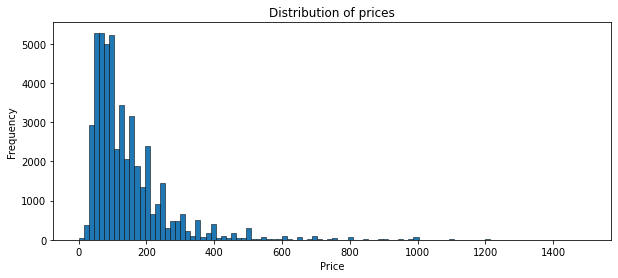

In [9]:
plt.figure(figsize=(10, 4))

sns.histplot(df[df['price']<1500].price, bins=100, alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

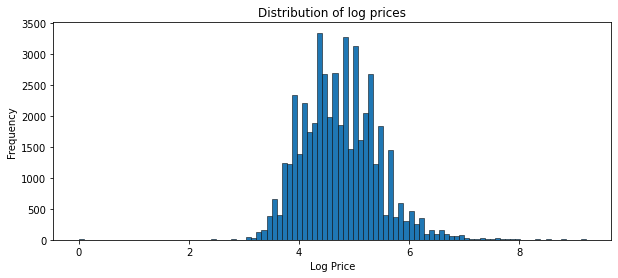

In [10]:
df['log_price'] = np.log1p(df['price'])

plt.figure(figsize=(10, 4))

sns.histplot(df.log_price, bins=100, alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Log Price')
plt.title('Distribution of log prices')

plt.show()

Question 1:
Find a feature with missing values. How many missing values does it have?

In [11]:
features = ['latitude',
            'longitude',
            'price',
            'minimum_nights',
            'number_of_reviews',
            'reviews_per_month',
            'calculated_host_listings_count',
            'availability_365'
            ]

In [12]:
features_lr = ['latitude',
            'longitude',
            'minimum_nights',
            'number_of_reviews',
            'reviews_per_month',
            'calculated_host_listings_count',
            'availability_365'
            ]

In [13]:
df[features].isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [14]:
df[features].isnull().sum().sum()

10052

Question 2:
What's the median (50% percentile) for variable 'minimum_nights'?

In [15]:
df[features].minimum_nights.median()

3.0

Split the data:

Shuffle the initial dataset, use seed 42.
Split your data in train/val/test sets, with 60%/20%/20% distribution.

Make sure that the target value ('price') is not in your dataframe.

Apply the log transformation to the price variable using the np.log1p() function.

In [16]:
np.random.seed(42)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [17]:
y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

In [18]:
df[['log_price']]

,log_price
0,5.0106
1,5.4205
2,5.0173
3,4.4998
4,4.3944
...,...
48890,4.2627
48891,3.7136
48892,4.7536
48893,4.0254


Question 3:
We need to deal with missing values for the column from Q1. We have two options: 

fill it with 0 or with the mean of this variable.
Try both options. 

For each, train a linear regression model without regularization using the code from the lessons.
For computing the mean, use the training only!

Use the validation dataset to evaluate the models and compare the RMSE of each option.

Round the RMSE scores to 2 decimal digits using round(score, 2). Which option gives better RMSE?

In [19]:
df_train['reviews_per_month'].isnull().sum(), df_val['reviews_per_month'].isnull().sum(), df_test['reviews_per_month'].isnull().sum()

(5998, 2051, 2003)

Linear Regression:

In [20]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [21]:
def prepare_X(df, fill):
    df_num = df[features_lr]
    df_num = df_num.fillna(fill)
    X = df_num.values
    return X

Fill it with 0 or with the mean of this variable.
Try both options:

In [22]:
X_mean = prepare_X(df_train, df_train['reviews_per_month'].mean())
X_cero = prepare_X(df_train, 0)

For each, train a linear regression model without regularization using the code from the lessons:

In [23]:
train_linear_regression(X_mean, y_train)

(-423.5393076139524,
 array([ 1.31148321e+00, -5.06799071e+00, -4.87741552e-04, -6.63849280e-04,
         5.34563271e-03,  1.32706020e-03,  6.38794182e-04]))

In [24]:
train_linear_regression(X_cero, y_train)

(-419.91265807142094,
 array([ 1.30676225e+00, -5.02167854e+00, -5.59803109e-04, -4.07634896e-04,
        -8.25470069e-03,  1.33371320e-03,  6.50203890e-04]))

In [25]:
pd.DataFrame(X_mean)

,0,1,2,3,4,5,6
0,40.6435,-73.9778,3.0000,62.0000,0.7100,1.0000,189.0000
1,40.7067,-73.9078,21.0000,0.0000,1.3685,1.0000,73.0000
2,40.7612,-73.9902,2.0000,17.0000,0.4300,1.0000,0.0000
3,40.7076,-74.0105,2.0000,5.0000,1.8800,327.0000,272.0000
4,40.7966,-73.9329,2.0000,30.0000,0.8000,1.0000,30.0000
...,...,...,...,...,...,...,...
29332,40.7118,-73.9578,2.0000,0.0000,1.3685,1.0000,0.0000
29333,40.7864,-73.9700,30.0000,10.0000,0.4000,1.0000,0.0000
29334,40.7272,-73.9852,3.0000,75.0000,3.1200,1.0000,60.0000
29335,40.7958,-73.9452,2.0000,31.0000,2.1000,1.0000,265.0000


In [26]:
df_val_mean = df_val[features_lr].fillna(df_train['reviews_per_month'].mean())
df_val_cero = df_val[features_lr].fillna(0)

Use the validation dataset to evaluate the models and compare the RMSE of each option.

In [27]:
w_0, w = train_linear_regression(X_mean, y_train)
y_pred_mean = w_0 + df_val_mean.dot(w)

In [28]:
w_0, w = train_linear_regression(X_cero, y_train)
y_pred_cero = w_0 + df_val_cero.dot(w)

In [29]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [30]:
rmse(y_val, y_pred_cero)

0.6430337788584171

In [31]:
rmse(y_val, y_pred_mean)

0.6427545031727655

In [32]:
rmse(y_val, y_pred_cero ) < rmse(y_val, y_pred_mean)

False

Question 4:
Now let's train a regularized linear regression.
For this question, fill the NAs with 0.
Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].

Use RMSE to evaluate the model on the validation dataset.
Round the RMSE scores to 2 decimal digits.

Which r gives the best RMSE?
If there are multiple options, select the smallest r.

Regularization

In [33]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [34]:
list_of_r = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

In [35]:
train_linear_regression_reg(X_cero, y_train, 0)

(-419.91265807142094,
 array([ 1.30676225e+00, -5.02167854e+00, -5.59803109e-04, -4.07634896e-04,
        -8.25470069e-03,  1.33371320e-03,  6.50203890e-04]))

In [36]:
rmse_r = []
for r in list_of_r:
  w_0, w = train_linear_regression_reg(X_cero, y_train, r)
  y_pred = w_0 + df_val_cero.dot(w)
  print(r, rmse(y_val, y_pred))
  rmse_r.append(rmse(y_val, y_pred))

0 0.6430337788584171
1e-06 0.643034115747927
0.0001 0.6430723153561922
0.001 0.6437669735361428
0.01 0.6557528427479221
0.1 0.6773299642454964
1 0.6823116950156253
5 0.68279157278493
10 0.6828430212097037


In [37]:
min(rmse_r)

0.6430337788584171

Question 5: 
We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.

Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].

For each seed, do the train/validation/test split with 60%/20%/20% distribution. Fill the missing values with 0 and train a model without regularization.

For each seed, evaluate the model on the validation dataset and collect the RMSE scores.

What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
Round the result to 3 decimal digits (round(std, 3))

Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.

In [42]:
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
results = []

In [43]:
np.random.seed(0)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

def prepare_0(df):
    df_num = df[features_lr]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

df_train = prepare_0(df_train)
df_val = prepare_0(df_val)
df_test = prepare_0(df_test)

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

w_0, w = train_linear_regression(df_train, y_train)
y_pred = w_0 + df_val.dot(w)

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

results.append(rmse(y_val, y_pred))

In [44]:
np.random.seed(1)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

def prepare_0(df):
    df_num = df[features_lr]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

df_train = prepare_0(df_train)
df_val = prepare_0(df_val)
df_test = prepare_0(df_test)

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

w_0, w = train_linear_regression(df_train, y_train)
y_pred = w_0 + df_val.dot(w)

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

results.append(rmse(y_val, y_pred))

In [45]:
np.random.seed(2)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

def prepare_0(df):
    df_num = df[features_lr]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

df_train = prepare_0(df_train)
df_val = prepare_0(df_val)
df_test = prepare_0(df_test)

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

w_0, w = train_linear_regression(df_train, y_train)
y_pred = w_0 + df_val.dot(w)

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

results.append(rmse(y_val, y_pred))

In [46]:
np.random.seed(3)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

def prepare_0(df):
    df_num = df[features_lr]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

df_train = prepare_0(df_train)
df_val = prepare_0(df_val)
df_test = prepare_0(df_test)

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

w_0, w = train_linear_regression(df_train, y_train)
y_pred = w_0 + df_val.dot(w)

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

results.append(rmse(y_val, y_pred))

In [47]:
np.random.seed(4)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

def prepare_0(df):
    df_num = df[features_lr]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

df_train = prepare_0(df_train)
df_val = prepare_0(df_val)
df_test = prepare_0(df_test)

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

w_0, w = train_linear_regression(df_train, y_train)
y_pred = w_0 + df_val.dot(w)

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

results.append(rmse(y_val, y_pred))

In [48]:
np.random.seed(5)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

def prepare_0(df):
    df_num = df[features_lr]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

df_train = prepare_0(df_train)
df_val = prepare_0(df_val)
df_test = prepare_0(df_test)

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

w_0, w = train_linear_regression(df_train, y_train)
y_pred = w_0 + df_val.dot(w)

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

results.append(rmse(y_val, y_pred))

In [49]:
np.random.seed(6)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

def prepare_0(df):
    df_num = df[features_lr]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

df_train = prepare_0(df_train)
df_val = prepare_0(df_val)
df_test = prepare_0(df_test)

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

w_0, w = train_linear_regression(df_train, y_train)
y_pred = w_0 + df_val.dot(w)

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

results.append(rmse(y_val, y_pred))

In [50]:
np.random.seed(7)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

def prepare_0(df):
    df_num = df[features_lr]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

df_train = prepare_0(df_train)
df_val = prepare_0(df_val)
df_test = prepare_0(df_test)

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

w_0, w = train_linear_regression(df_train, y_train)
y_pred = w_0 + df_val.dot(w)

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

results.append(rmse(y_val, y_pred))

In [51]:
np.random.seed(8)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

def prepare_0(df):
    df_num = df[features_lr]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

df_train = prepare_0(df_train)
df_val = prepare_0(df_val)
df_test = prepare_0(df_test)

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

w_0, w = train_linear_regression(df_train, y_train)
y_pred = w_0 + df_val.dot(w)

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

results.append(rmse(y_val, y_pred))

In [52]:
np.random.seed(9)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

def prepare_0(df):
    df_num = df[features_lr]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

df_train = prepare_0(df_train)
df_val = prepare_0(df_val)
df_test = prepare_0(df_test)

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

w_0, w = train_linear_regression(df_train, y_train)
y_pred = w_0 + df_val.dot(w)

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

results.append(rmse(y_val, y_pred))

In [53]:
results

[0.6549779961157263,
 0.646252368578719,
 0.6476558177163445,
 0.6375145071233626,
 0.6445809083551755,
 0.6305809996077186,
 0.6297851917617103,
 0.6506184267164312,
 0.6489780353432693,
 0.6437565168302604]

In [56]:
round(np.std(results), 3)

0.008

Question 6:

Split the dataset like previously, use seed 9.
Combine train and validation datasets.
Fill the missing values with 0 and train a model with r=0.001.
What's the RMSE on the test dataset?

In [70]:
np.random.seed(9)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = pd.DataFrame(np.log1p(df_train.price.values))
y_val = pd.DataFrame(np.log1p(df_val.price.values))
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

def prepare_0(df):
    df_num = df[features_lr]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

df_train = pd.DataFrame(prepare_0(df_train))
df_val = pd.DataFrame(prepare_0(df_val))
df_test = prepare_0(df_test)

def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

w_0, w = train_linear_regression_reg(pd.concat([df_train, df_val]), pd.concat([y_train, y_val]), 0.001)
y_pred = w_0 + df_test.dot(w)

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

rmse(y_test, y_pred)

0.7390321239198335